In [170]:
import pandas as pd
import numpy as np
from pystan import StanModel
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az

In [171]:
read_data = pd.read_csv(r'fatal_accidents.csv')
read_data

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


### Exercise 1

The rate is constant for all years and not depending on anything.

* Prior distribution for constant accidents rate

Firstly, we want to create Poisson distribution with constant rate(lambda), which is not dependent on any other parameter. We can calculate lambda by solving polynomial equation. We are looking for lambda parameter for which is less then 1% of probability that 2 passangers will die per day.

In [172]:
root_of_lam=np.polynomial.polynomial.polyroots([-730.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print("Root: "+ str(lam_ub))

Root: [653.]


Below we can see stan model of half-normal distribution (-0,5). That model give us 99% of probability that less than 2 people are dying because of aircraft disaster everyday. Our prior need to have probability of lambda equal to 99%.

In [173]:
with open('zad1.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; 
  vector[1] theta;
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
  real sigma = exp(y[1]);
}


In [176]:
model_prior_no_params = StanModel('zad1.stan')
data = {'y_guess': np.array([np.log(565)]), 'theta': np.array([653])}
modelmodel_prior_no_params_val = model_prior_no_params.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2883caa00e87b52d6a3c385661ce469 NOW.


In [177]:
sigma = modelmodel_prior_no_params_val.extract()['sigma'][0]
print("Sigma: " + str(sigma))

Sigma: 253.51058748353978


Our model calculations shows that having half-normal distribution in range between (0, 253) will quarantee that only there will only be 1% of probability of more that 2 passangers deaths per day. 

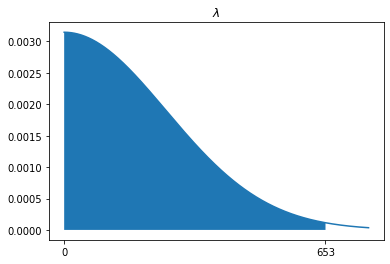

In [178]:
fig, ax2 = plt.subplots(1, 1)
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

* Prior predictive distribution based on prior information (number of years)

Below, we model our distribution with assumption that normal distribution have previously calculated lambda value equal to 253. Half-normal distribution with interval (0, 253) will guarantee us 99% of probability below 653.

In [180]:
with open('zad1B.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0,253));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [181]:
model_prior_params = StanModel('zad1B.stan')
data = {'M': len(read_data)}
model_prior_params_val = model_prior_params.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b41912afb85f2a45d9045263f16dadd2 NOW.


In [182]:
lambda_prior_params = model_prior_params_val.extract()['lambda']
y_prior_params = model_prior_params_val.extract()['y_sim']

Plotting both half-normal and predictive prior distribution.

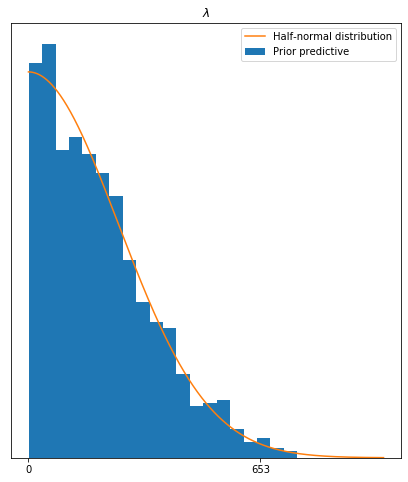

In [185]:
fig, ax1 = plt.subplots(1, 1,figsize=(7, 8))
ax1.hist(lambda_prior_params, bins=20, density=True, label = 'Prior predictive')
x=np.linspace(0,1000,20000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,253), label = 'Half-normal distribution')
ax1.legend(prop = {'size': 10})

plt.show()

* Posterior distribution

Now we are creating posterior model.

In [186]:
with open('zad1_posterior.stan', 'r') as file:
    print(file.read())

data {
    int M;
    int y[M];
}
parameters {
    real<lower=0>lambda;
}
model {
    lambda ~ normal(0, 253);
    for (k in 1:M) {
        y[k] ~ poisson(lambda);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(lambda);
    }
}


In [187]:
model_posterior = StanModel('zad1_posterior.stan')
data = {'M': len(read_data), 'y': read_data[' Passenger deaths']}
model_posterior_val = model_posterior.sampling(data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e142190e3f55aa7d4b9336c4a1ab306 NOW.


We are able to calculate the mean and interval in which 99% of probability, that less than 2 passangers per day will die, is located.

In [188]:
lambda_posterior = model_posterior_val.extract()['lambda']
y_posterior = model_posterior_val.extract()['y_sim'].flatten()
y_interval = az.hpd(lambda_posterior,0.99)
y_interval

array([668.2218347 , 711.83319362])

In [189]:
print('Mean lambda: ' + str(np.mean(lambda_posterior)))
print('909% confidence: ['+ str(y_interval[0]) + ' ' + str(y_interval[1]) +']')

Mean lambda: 691.1940177619048
909% confidence: [668.2218346987045 711.8331936164341]


Now we are plotting in order to present calculated values.

a) Poisson distribution - interval bounds are marked

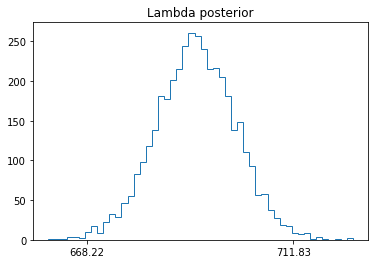

In [190]:
fig, ax2 = plt.subplots(1, 1)
ax2.set_title('Lambda posterior')
ax2.hist(lambda_posterior, histtype = 'step', bins = 50)
ax2.set_xticks([y_interval[0], y_interval[1]])
plt.show()

Prediction of death rate from the model.

In [191]:
predict_mean = np.median(y_posterior)
predict_interval = az.hpd(y_posterior, 0.99)
print('Mean: ' + str(predict_mean))
print('Interval: [' + str(predict_interval[0]) + ',' + str(predict_interval[1]) + ']')

Mean: 691.0
Interval: [623.0,764.0]


### Exercise 2

The intensity is constant, but rate is a product of intensity and miles flown.

* Prior distribution

Now we want to create Poisson distribution with rate(theta), which is dependent on other parameter(intensity and miles flown). We can calculate lambda by solving polynomial equation which contains additional information:
n - mean of miles flown. We are looking for theta parameter for which is less then 1% of probability that 2 passangers will die per day.

In [192]:
mean_miles=np.mean(read_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-730/mean_miles,3./np.sqrt(mean_miles),1.])
lam_ub=(root_of_theta[root_of_lam>0]**2)
print("Root: "+ str(lam_ub))

Root: [0.11430065]


Stan model looks the same as model in exercise 1, so we are using that one with a assumption of lambda parameter.

In [193]:
with open('zad1.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; 
  vector[1] theta;
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
  real sigma = exp(y[1]);
}


In [194]:
model_prior_no_params = StanModel('zad1.stan')
data = {'y_guess': np.array([np.log(0.1)]), 'theta': np.array([0.11430065])}
modelmodel_prior_no_params_val = model_prior_no_params.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2883caa00e87b52d6a3c385661ce469 NOW.


In [195]:
sigma = modelmodel_prior_no_params_val.extract()['sigma'][0]
print("Sigma: " + str(sigma))

Sigma: 0.044374310767611745


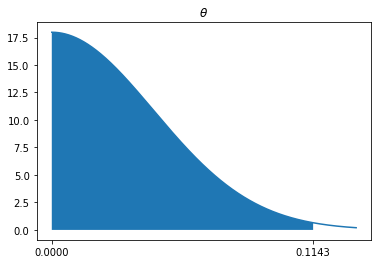

In [196]:
fig, ax2 = plt.subplots(1, 1)
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

* Prior predictive distribution based on prior information (number of years, miles flown).
Half-normal distribution with interval (0, 0.04) will guarantee us 99% of probability below 0.11.

In [197]:
with open('zad2_prior_predective.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}

generated quantities {
  real theta=fabs(normal_rng(0,0.044));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [199]:
model_prior_params = StanModel('zad2_prior_predective.stan')
data = {'M': len(read_data), 'miles': read_data['Miles flown [100 mln miles]']}
model_prior_params_val = model_prior_params.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_021772cd3e1b5f7f6157f00b2fa3c67d NOW.


In [200]:
theta_prior_params = model_prior_params_val.extract()['theta']
y_prior_params = model_prior_params_val.extract()['y_sim']

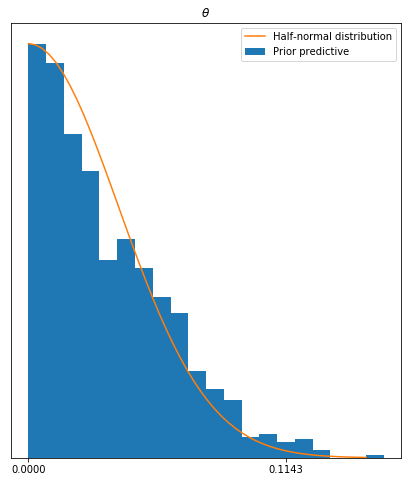

In [201]:
fig, ax1 = plt.subplots(1, 1,figsize=(7, 8))
ax1.hist(theta_prior_params, bins=20, density=True, label = 'Prior predictive')
x=np.linspace(0,0.15)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,0.04), label = 'Half-normal distribution')
ax1.legend(prop = {'size': 10})

plt.show()

* Posterior distribution

Now we are able to prepare posterior interference.

In [202]:
with open('zad2_posterior.stan', 'r') as file:
    print(file.read())

data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.044);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(miles[k]*theta);
    }
}


In [203]:
model_posterior = StanModel('zad2_posterior.stan')
data = {'M': len(read_data), 'miles': read_data['Miles flown [100 mln miles]'], 'y': read_data[' Passenger deaths']}
model_posterior_val = model_posterior.sampling(data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cd0324e85210abf95d5e06db85a29f2 NOW.


In [204]:
theta_posterior = model_posterior_val.extract()['theta']
y_posterior = model_posterior_val.extract()['y_sim'].flatten()
y_interval = az.hpd(theta_posterior,0.99)
y_interval

array([0.11702942, 0.12440858])

In [205]:
print('Mean theta: ' + str(np.mean(lambda_posterior)))
print('909% confidence: ['+ str(y_interval[0]) + ' ' + str(y_interval[1]) +']')

Mean theta: 691.1940177619048
909% confidence: [0.11702941792024313 0.1244085803801455]


We are plotting theta - posterioir with interval bounds marked. Interval bounds shows bound of probability equal to 99%.

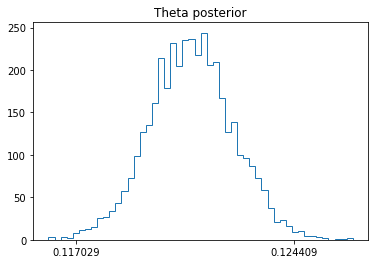

In [206]:
fig, ax2 = plt.subplots(1, 1)
ax2.set_title('Theta posterior')
ax2.hist(theta_posterior, histtype = 'step', bins = 50)
ax2.set_xticks([y_interval[0], y_interval[1]])
plt.show()

* Using our model

Now we might predict passengers deaths in 1986 (out of read_data).

In [207]:
with open('usage.stan', 'r') as file:
    print(file.read())

data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.11);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y1986 = poisson_rng(9100*theta);
}


In [208]:
model_posterior = StanModel('usage.stan')
data = {'M': len(read_data), 'miles': read_data['Miles flown [100 mln miles]'], 'y': read_data[' Passenger deaths']}
model_posterior_val = model_posterior.sampling(data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ed13c7b6e7309594617caa33d8fceef NOW.


In [209]:
theta_posterior = model_posterior_val.extract()['theta']
y_posterior_usage = model_posterior_val.extract()['y1986'].flatten()
y_interval = az.hpd(theta_posterior,0.99)
print('Mean theta: ' + str(np.mean(lambda_posterior)))
print('99% confidence: ['+ str(y_interval[0]) + ' ' + str(y_interval[1]) +']')

Mean theta: 691.1940177619048
99% confidence: [0.11766340714604083 0.1251231297021948]


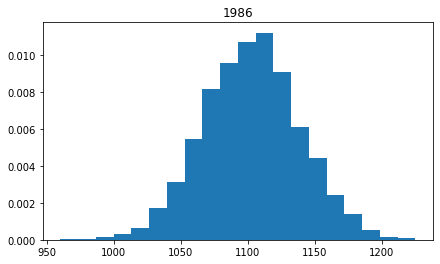

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_posterior_usage,bins=20,density=True)
ax.set_title('1986')
plt.show()